In [1]:
%matplotlib inline

**Problém 1**: Rovnice advekce-difůze 

$$
\frac{\partial u}{\partial t} + v \frac{\partial u}{\partial x} = D\frac{\partial^2 u}{\partial t^2}
$$


najděte numerické řešení v intervalu $x = [1, 2]$ a s počatečními podmínkami $u = 1$ pro $x \leq 1.5$ a $u = 0$ pro $x > 1.5$. Vyzkoušejte různé hodnoty konstantni rychlosti advekce $v$ a koeficientu difůze.

Nejprve naimportujeme potřebné knihovny pro práci s poli a kreslení

In [2]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt

Dále je potřeba určit počáteční podmínky našeho problému, správněji řečeno profil funkce $u(x,t=0)$. Pro naše účely si vystačíme s jednoduchým profilem ve tvaru obdelníkového pulsu a schodu.

In [3]:
def box_profile(x):
    
    u = np.ones_like(x)
    ubound = np.where(x >= 0.5)
    lbound = np.where(x <= 1)
    u[np.intersect1d(lbound,ubound)] = 2.0
    
    return u

def step_profile(x):
    u = np.ones_like(x); u[x > 1.5] = 0
    return u

## Gaussian profile
def gaussian(x):
    mu = 1.0
    sig2 = 0.1
    return 1.0/(np.sqrt(2.*np.pi*sig2))*np.exp(-np.power(x - mu, 2.)/(2.0*sig2))

Abychom se ujistili, že jsou naše počáteční podmínky správně, zobrazíme si tvar obou dvou profilů s využitím knihovny matplotlib

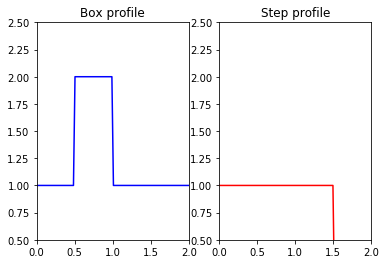

In [4]:
x = np.linspace(0, 2, 100)
u1 = box_profile(x)
u2 = step_profile(x)

plt.figure(1)

plt.subplot(121)
plt.title('Box profile')
plt.ylim((0.5,2.5))
plt.xlim((0,2))
plt.plot(x, u1, 'b-')

plt.subplot(122)
plt.title('Step profile')
plt.ylim(0.5,2.5)
plt.xlim((0,2))
plt.plot(x,u2,'r-')

Pro zobrazení finálního výsledku si připravíme funkci, která vykreslí numerické řešení...

In [5]:
def plot_result(x,u,title=' ',xmin=0.0,xmax=2.0,ymin=0.5,ymax=2.5):
    ## Plotting of the result      
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.ylim((ymin,ymax))
    plt.xlim((xmin,xmax))
    plt.plot(x, u)
    plt.grid(True)

### Laxova-Friedrichsova metoda ###
Jako první metodu pro řešení rovnice advekce-difůze, použijeme Laxovu metodu, viz [Lax-Friedrichs](https://en.wikipedia.org/wiki/Lax%E2%80%93Friedrichs_method). Funkce bude mít jako vstupní parametry čas a rychlost advekce. Hodnotu parametrů rychlosti advekce $v$ zvolíme pro jednoduchost nulovou, bude se tedy jednat o difůzní problém, tomu také odpovídá velikost zvoleného časového kroku

In [6]:
def lax_friedrichs_method(time = 1.0, velocity=0.3):
    
    number_of_points = 100
    
    D = 0.00001
    v = velocity
    t_end = time

    x,dx = np.linspace(0., 2., number_of_points,retstep=True)

    cdif = 0.4
    ccfl = 0.4
    diffusion_time = cdif*dx**2/(2.0*D)
    advection_time = ccfl*dx/v
    dt = min(diffusion_time,advection_time)
    
    u = gaussian(x)
    
    cas = 0.0
    
    
    alpha = v*dt/dx
    beta = D*dt/dx**2.0
    
    while cas < t_end:

        u[1:-1] = u[:-2]*(0.5+alpha*0.5+beta)-u[1:-1]*2.0*beta+u[2:]*(0.5-0.5*alpha+beta)
        u[0] = u[1]
        u[number_of_points-1] = u[number_of_points-2]
        cas = cas + dt
        
    return x,u


Nyní nám již nic nebrání v otestování našeho numerického řešení. Spustíme funkci a vykreslíme vysledný průběh. Použijeme přitom také magický příkaz **%time**, který nám vypíše dobu výpočtu - položka *Wall time*. 

CPU times: user 1.38 ms, sys: 0 ns, total: 1.38 ms
Wall time: 1.13 ms


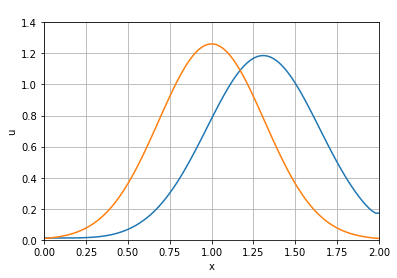

In [7]:
u_initial = gaussian(x)
%time x,u = lax_friedrichs_method()
plot_result(x,u,ymin=0.,ymax=1.4)
plot_result(x,u_initial,ymin=0.,ymax=1.4)

Jak je vidno, metoda pracuje relativně dobře pokud se jedná o problém lineární advekce, nicméně přídaním difůzního členu se situace radikálně změní. 

### Aktivity

* Vyzkoušejte si ruzné hodnoty koeficientu difůze $D$ a analyzujte změnu chování.

#### Poznámka
Při konstrukci kódu jsme v rámci urychlení využili *slice* indexování v PYTHONu (více viz. [Slicing](http://docs.scipy.org/doc/numpy-1.10.0/reference/arrays.indexing.html)). Výhodou je, že v této formě lze použít vektorový přístup při výpočtu, což významně zefektivní výpočet. V budoucnu tedy použijeme vždy vektorové formy s pomocí již zmíněného *slice* indexování

Mnohem vhodnější metodou pro problém *difůze-advekce* je konzervativní schéma [Lax-Wendorf](https://en.wikipedia.org/wiki/Lax%E2%80%93Wendroff_method). Modifikujeme tedy předchozí kód pro tuto metodu

In [8]:
def lax_wendorf_method(time = 1.0, velocity=0.3):
    
    number_of_points = 100
    
    D = 0.1
    v = velocity
    t_end = time

    x,dx = np.linspace(0., 2., number_of_points,retstep=True)
    
    cdif = 0.4
    ccfl = 0.4
    diffusion_time = cdif*dx**2/(2.0*D)
    advection_time = ccfl*dx/v
    dt = min(diffusion_time,advection_time)

    u = gaussian(x)
    
    cas = 0.0
    
    alpha = v*dt/dx
    beta = D/dx
    
    while cas < t_end:

        u[1:-1] = u[:-2]*(0.5*alpha+alpha**2.0/(2.0*dt)+alpha*beta)+u[1:-1]*(1.0-alpha**2.0/dt-2.0*beta*alpha)+u[2:]*(-0.5*alpha+alpha**2.0/(2.0*dt)+alpha*beta)
        u[0] = u[1]
        u[number_of_points-1] = u[number_of_points-2]
        cas = cas + dt
        
    return x,u

A porovnáme dobu výpočtu

CPU times: user 19.5 ms, sys: 773 µs, total: 20.3 ms
Wall time: 16.8 ms


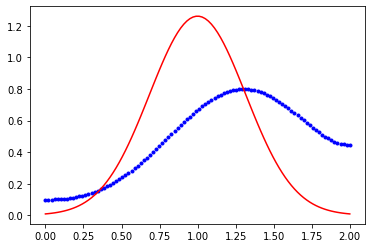

In [9]:
%time x,u = lax_wendorf_method()

plt.plot(x,u,'b.')
plt.plot(x,gaussian(x),'r-')

Vidíme, že doba výpočtu se zkrátila zhruba 17-násobně.

IPython však umí mnohem více, určitě by bylo vhodné mít možnost měnit hodnoty řídích parametrů problému a neomezovat se tak pouze na pevně zvolené. Lze tím ilustrovat vliv řídících parametru na řešení problému. Typicky zvětšováním hodnoty difůze se stane proces difůze dominantním, analogicky pak zvětšování hodnoty rychlosti zase proces advekce. To má ovšem značný vliv na stabilitu numerického řešení, jak si ukážeme v další části.

In [10]:
from ipywidgets import interact

@interact(t_end=(0, 1.0), velocity=(0.0, 1.0), D = (0.01,0.5))
def lax_method(t_end=0.1,velocity=0.0,D=0.3):
    D = D
    v = velocity
    t_end = t_end
    
    number_of_points = 104
    dx = 2./(number_of_points-1)
    
    x = np.linspace(0, 2, number_of_points)
    dt = 0.2*dx**2.0/D
    
    u = box_profile(x)
    
    time = 0.0
    
    while time < t_end:
        uu = np.copy(u)

        u[1:number_of_points-2] =uu[1:number_of_points-2]-\
        v*dt/dx*(uu[1:number_of_points-2]-uu[:number_of_points-3])+D*dt/(dx*dx)*\
        (uu[2:number_of_points-1]-2*uu[1:number_of_points-2]+uu[:number_of_points-3])

        u[0] = u[1]
        u[number_of_points-1] = u[number_of_points-2]

        time = time + dt
    plot_result(x,u)
    return

interactive(children=(FloatSlider(value=0.1, description='t_end', max=1.0), FloatSlider(value=0.0, description…

### Crank-Nicholsonova metoda ###
Předchozí metoda řešení rovnice advekce-difůze použila explicitní schéma, můžeme však použít (a mnohdy je to i velmi vhodne) implicitní schéma. Nejznámějším příkladem takého schématu je *Crankovo-Nicholsonovo* schéma. V implicitním diferenčním schématu dostaneme výsledek řešením soustavy lineárních rovnic v maticovém zápisu. S výhodou tak využijeme modul [*linalg*](https://docs.scipy.org/doc/scipy/reference/linalg.html) v rámci balíčku *Scipy*, který obsahuje spoustu již hotových metod pro řešení takové soustavy.

In [12]:
import scipy.linalg as sp

@interact(t_end=(0.0,0.2),velocity=(0.01,1.2),D=(0.0,0.3))
def crank_nicholson(t_end,velocity,D):
    
    #Inicializace poli
    number_of_points = 100
    u = np.empty(number_of_points+2)
    x = np.linspace(1,2,number_of_points+2)
    u = np.ones_like(x); u[x > 1.5] = 0

    # Prostorovy a casovy krok
    dx = x[1]-x[0]
    D = D
    
    # Parametry problemu 
    # v ... rychlost je kladna, zaporne znamenko vznika prechodem na druhou stranu
    
    v = -velocity
    dt = 0.005
    t_end = t_end

    main = np.empty(number_of_points)
    lower = np.empty(number_of_points -1)
    upper = np.empty(number_of_points -1)
 
    right_side = np.empty(number_of_points)

    matrix = np.zeros((number_of_points, number_of_points))

    # Koefecienty pro jednotlive cleny pravych stran
    sigma = D*dt/(2.0*dx*dx)
    rho = v*dt/(4.0*dx)

    main[:] = (1.0+2.0*sigma)
    upper[:] = -(sigma+rho)
    lower[:] = (-sigma+rho)

    # Boundary condition
    main[0] = (1.0+sigma+rho)
    main[number_of_points-1] = (1.0+sigma-rho)

    for i in range(number_of_points):
        matrix[i,i] = main[i]
    
    for i in range(number_of_points-1):
        matrix[i+1,i] = lower[i]
        matrix[i,i+1] = upper[i]

    cas = 0.0

    # Hlavni cyklus
    while cas < t_end:
        right_side[1:number_of_points] = u[1:number_of_points]*(1.0-2.0*sigma)+u[2:number_of_points+1]*(sigma+rho)+\
        u[0:number_of_points-1]*(sigma-rho)


        # boundary condition 
        right_side[0] = u[0]*(1.0-sigma-rho)+(sigma+rho)*u[1]
        right_side[number_of_points-1] = u[number_of_points-2]*(sigma-rho)+(1.0-sigma+rho)*u[number_of_points-1]
    
        solution = sp.solve(matrix,right_side)
        u[1:number_of_points+1]=solution
        cas = cas + dt
        
    plot_result(x,u,title='Crank-Nicholson',xmin=1.0,xmax=2.0,ymin=0,ymax=1.2)
    return x,u

interactive(children=(FloatSlider(value=0.1, description='t_end', max=0.2), FloatSlider(value=0.605, descripti…

CPU times: user 124 ms, sys: 93.1 ms, total: 217 ms
Wall time: 73.2 ms


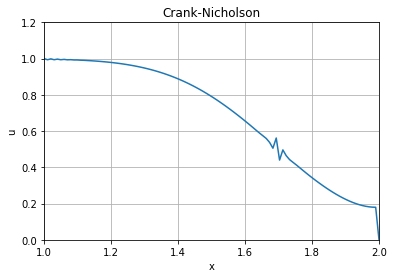

In [13]:
%time x,u = crank_nicholson(t_end=0.1, velocity=0.0, D = 0.3)

### Aktivity

* Vyzkoušejte si různé metody řešení rovnice *advekce-difůze* pro **D=0**. Jedná se o speciální případ této rovnice popisující advekci, 
v literatuře uváděnou jako [nevazká *Burgersova*](https://en.wikipedia.org/wiki/Burgers%27_equation) rovnice. Analyzujte změnu chování. Diskutujte vliv difůzního koeficientu **D**

#### Poznámka
Pro úplnost dodávám, že rovnice *advekce-difůze* známá též jako *Burgersova* rovnice. Její *nevazká* varianta je nejednoduším případem parciální diferenciální rovnice, která umožňuje vznik rázové vlny. Vámi zvolené řešení můžete porovnat s námi zvoleným [řešením *Burgersovy*](Burgersova-rovnice.ipynb) rovnice.